In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Matplotlib is building the font cache; this may take a moment.


In [16]:
import boto3
from io import StringIO

s3_uri = 's3://220103263-bucket/csv_files/raw_data.csv'

# Загрузка напрямую через pandas
df = pd.read_csv(s3_uri)

# Просмотр данных
df.head()

,Price,From,To,curr_date,departure_date,arrival_date,is_holiday,is_weekends,time_interval,avialine,duration
0,37864,Алматы,Атырау,2024-12-16,2024-12-19 20:55,2024-12-20 00:15,False,False,20:55-00:15,Air Astana,200
1,37864,Алматы,Атырау,2024-12-16,2024-12-19 06:45,2024-12-19 10:00,False,False,06:45-10:00,Air Astana,195
2,37864,Алматы,Атырау,2024-12-16,2024-12-22 06:45,2024-12-22 10:00,False,True,06:45-10:00,Air Astana,195
3,28356,Алматы,Атырау,2024-12-16,2024-12-23 06:45,2024-12-23 10:00,False,False,06:45-10:00,Air Astana,195
4,29220,Алматы,Атырау,2024-12-16,2024-12-23 09:20,2024-12-23 12:30,False,False,09:20-12:30,SCAT,190


In [17]:
df.duplicated().sum()

49

In [18]:
df = df.drop_duplicates()

In [19]:
df.shape

(2147, 11)

In [20]:
def remove_outliers_flyarystan(df):
    group = df[df["avialine"] == "FlyArystan"]
    Q1 = group["Price"].quantile(0.25)
    Q3 = group["Price"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    flyarystan_cleaned = group[(group["Price"] >= lower) & (group["Price"] <= upper)]
    
    others = df[df["avialine"] != "FlyArystan"]
    return pd.concat([flyarystan_cleaned, others], axis=0).reset_index(drop=True)

df = remove_outliers_flyarystan(df)

In [21]:
df.shape

(2114, 11)

In [22]:
df = df.drop(columns=['arrival_date', 'is_weekends'])

In [23]:
df.shape

(2114, 9)

In [24]:
df['curr_date'] = pd.to_datetime(df['curr_date'])
df['departure_date'] = pd.to_datetime(df['departure_date'])

df['days_until_flight'] = (df['departure_date'] - df['curr_date']).dt.days

def get_part_of_day(time_str):

    start_hour = int(time_str.split('-')[0].split(':')[0])
    
    if 5 <= start_hour < 12:
        return 'утро'
    elif 12 <= start_hour < 17:
        return 'день'
    elif 17 <= start_hour < 22:
        return 'вечер'
    else:
        return 'ночь'

df['part_of_day'] = df['time_interval'].apply(get_part_of_day)
df

,Price,From,To,curr_date,departure_date,is_holiday,time_interval,avialine,duration,days_until_flight,part_of_day
0,25113,Алматы,Атырау,2024-12-16,2025-01-21 16:00:00,False,16:00-19:20,FlyArystan,200,36,день
1,23599,Алматы,Атырау,2024-12-16,2025-01-28 16:00:00,False,16:00-19:20,FlyArystan,200,43,день
2,23599,Алматы,Атырау,2024-12-16,2025-02-04 04:50:00,False,04:50-08:20,FlyArystan,210,50,ночь
3,23599,Алматы,Атырау,2024-12-16,2025-02-13 15:20:00,False,15:20-18:45,FlyArystan,205,59,день
4,26779,Алматы,Атырау,2024-12-16,2025-02-15 18:20:00,False,18:20-21:55,FlyArystan,215,61,вечер
...,...,...,...,...,...,...,...,...,...,...,...
2109,15664,Астана,Шымкент,2024-12-15,2025-02-28 10:30:00,False,10:30-12:10,SCAT,100,75,утро
2110,19146,Астана,Шымкент,2024-12-15,2025-02-28 23:20:00,False,23:20-01:00,SCAT,100,75,ночь
2111,15664,Астана,Шымкент,2024-12-15,2025-02-28 08:10:00,False,08:10-10:00,SCAT,110,75,утро
2112,19146,Астана,Шымкент,2024-12-15,2025-02-28 17:40:00,False,17:40-19:30,SCAT,110,75,вечер


In [25]:
print(df[['curr_date', 'departure_date', 'days_until_flight']].head())
print(df['part_of_day'].value_counts())

   curr_date      departure_date  days_until_flight
0 2024-12-16 2025-01-21 16:00:00                 36
1 2024-12-16 2025-01-28 16:00:00                 43
2 2024-12-16 2025-02-04 04:50:00                 50
3 2024-12-16 2025-02-13 15:20:00                 59
4 2024-12-16 2025-02-15 18:20:00                 61
утро     907
день     468
вечер    430
ночь     309
Name: part_of_day, dtype: int64


In [26]:
df['departure_dayofweek'] = df['departure_date'].dt.dayofweek
df['departure_month'] = df['departure_date'].dt.month

In [27]:
df

,Price,From,To,curr_date,departure_date,is_holiday,time_interval,avialine,duration,days_until_flight,part_of_day,departure_dayofweek,departure_month
0,25113,Алматы,Атырау,2024-12-16,2025-01-21 16:00:00,False,16:00-19:20,FlyArystan,200,36,день,1,1
1,23599,Алматы,Атырау,2024-12-16,2025-01-28 16:00:00,False,16:00-19:20,FlyArystan,200,43,день,1,1
2,23599,Алматы,Атырау,2024-12-16,2025-02-04 04:50:00,False,04:50-08:20,FlyArystan,210,50,ночь,1,2
3,23599,Алматы,Атырау,2024-12-16,2025-02-13 15:20:00,False,15:20-18:45,FlyArystan,205,59,день,3,2
4,26779,Алматы,Атырау,2024-12-16,2025-02-15 18:20:00,False,18:20-21:55,FlyArystan,215,61,вечер,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,15664,Астана,Шымкент,2024-12-15,2025-02-28 10:30:00,False,10:30-12:10,SCAT,100,75,утро,4,2
2110,19146,Астана,Шымкент,2024-12-15,2025-02-28 23:20:00,False,23:20-01:00,SCAT,100,75,ночь,4,2
2111,15664,Астана,Шымкент,2024-12-15,2025-02-28 08:10:00,False,08:10-10:00,SCAT,110,75,утро,4,2
2112,19146,Астана,Шымкент,2024-12-15,2025-02-28 17:40:00,False,17:40-19:30,SCAT,110,75,вечер,4,2


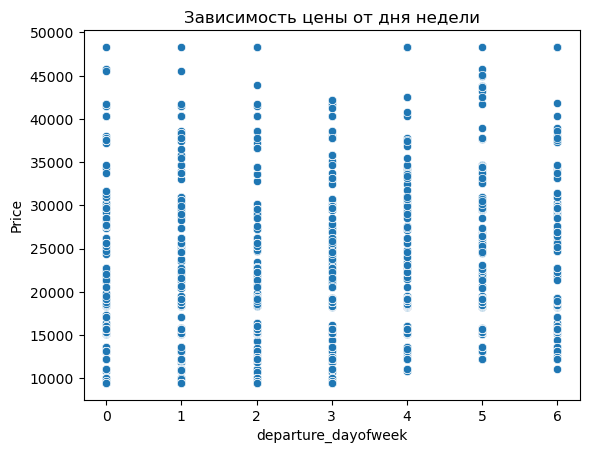

In [28]:
sns.scatterplot(x=df["departure_dayofweek"], y=df["Price"])
plt.title("Зависимость цены от дня недели")
plt.show()

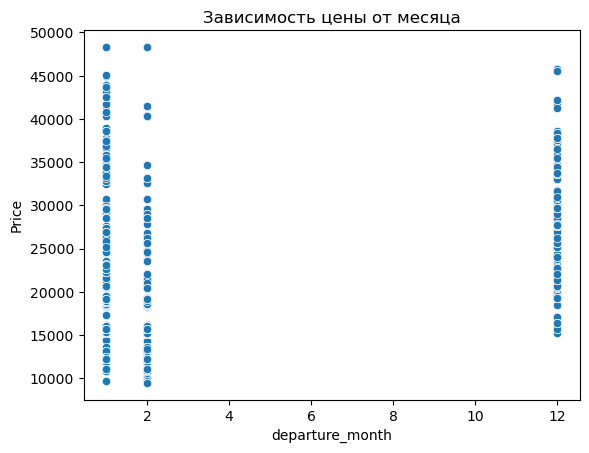

In [29]:
sns.scatterplot(x=df["departure_month"], y=df["Price"])
plt.title("Зависимость цены от месяца")
plt.show()

In [30]:
df = df.drop(columns=['curr_date', 'departure_date', 'time_interval', 'departure_dayofweek'])
df

,Price,From,To,is_holiday,avialine,duration,days_until_flight,part_of_day,departure_month
0,25113,Алматы,Атырау,False,FlyArystan,200,36,день,1
1,23599,Алматы,Атырау,False,FlyArystan,200,43,день,1
2,23599,Алматы,Атырау,False,FlyArystan,210,50,ночь,2
3,23599,Алматы,Атырау,False,FlyArystan,205,59,день,2
4,26779,Алматы,Атырау,False,FlyArystan,215,61,вечер,2
...,...,...,...,...,...,...,...,...,...
2109,15664,Астана,Шымкент,False,SCAT,100,75,утро,2
2110,19146,Астана,Шымкент,False,SCAT,100,75,ночь,2
2111,15664,Астана,Шымкент,False,SCAT,110,75,утро,2
2112,19146,Астана,Шымкент,False,SCAT,110,75,вечер,2


In [31]:
df = df.drop(columns=['departure_month'])
df

,Price,From,To,is_holiday,avialine,duration,days_until_flight,part_of_day
0,25113,Алматы,Атырау,False,FlyArystan,200,36,день
1,23599,Алматы,Атырау,False,FlyArystan,200,43,день
2,23599,Алматы,Атырау,False,FlyArystan,210,50,ночь
3,23599,Алматы,Атырау,False,FlyArystan,205,59,день
4,26779,Алматы,Атырау,False,FlyArystan,215,61,вечер
...,...,...,...,...,...,...,...,...
2109,15664,Астана,Шымкент,False,SCAT,100,75,утро
2110,19146,Астана,Шымкент,False,SCAT,100,75,ночь
2111,15664,Астана,Шымкент,False,SCAT,110,75,утро
2112,19146,Астана,Шымкент,False,SCAT,110,75,вечер


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Price              2114 non-null   int64 
 1   From               2114 non-null   object
 2   To                 2114 non-null   object
 3   is_holiday         2114 non-null   bool  
 4   avialine           2114 non-null   object
 5   duration           2114 non-null   int64 
 6   days_until_flight  2114 non-null   int64 
 7   part_of_day        2114 non-null   object
dtypes: bool(1), int64(3), object(4)
memory usage: 117.8+ KB


In [33]:
def preprocess(df, model_type):
    df = df.copy()

    df['Price'] = np.log1p(df['Price'])

    cat_features = ['From', 'To', 'avialine', 'part_of_day']
    num_features = ['duration', 'days_until_flight']

    if model_type == 'tree':
        for col in cat_features:
            df[col] = df[col].astype('category')

    elif model_type == 'linear':
        df = pd.get_dummies(df, columns=cat_features, drop_first=False)

        scaler = StandardScaler()
        df[num_features] = scaler.fit_transform(df[num_features])
    return df

df_prepared_tree = preprocess(df, model_type='tree')
df_prepared_linear = preprocess(df, model_type='linear')

In [34]:
df_prepared_tree

,Price,From,To,is_holiday,avialine,duration,days_until_flight,part_of_day
0,10.131181,Алматы,Атырау,False,FlyArystan,200,36,день
1,10.069002,Алматы,Атырау,False,FlyArystan,200,43,день
2,10.069002,Алматы,Атырау,False,FlyArystan,210,50,ночь
3,10.069002,Алматы,Атырау,False,FlyArystan,205,59,день
4,10.195411,Алматы,Атырау,False,FlyArystan,215,61,вечер
...,...,...,...,...,...,...,...,...
2109,9.659184,Астана,Шымкент,False,SCAT,100,75,утро
2110,9.859901,Астана,Шымкент,False,SCAT,100,75,ночь
2111,9.659184,Астана,Шымкент,False,SCAT,110,75,утро
2112,9.859901,Астана,Шымкент,False,SCAT,110,75,вечер


In [35]:
df_prepared_linear

,Price,is_holiday,duration,days_until_flight,From_Алматы,From_Астана,From_Шымкент,To_Алматы,To_Астана,To_Атырау,To_Шымкент,avialine_Air Astana,avialine_FlyArystan,avialine_Qazaq Air,avialine_SCAT,part_of_day_вечер,part_of_day_день,part_of_day_ночь,part_of_day_утро
0,10.131181,False,4.193800,-0.122540,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,10.069002,False,4.193800,0.203485,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,10.069002,False,4.658654,0.529510,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,10.069002,False,4.426227,0.948685,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
4,10.195411,False,4.891081,1.041835,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,9.659184,False,-0.454739,1.693885,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2110,9.859901,False,-0.454739,1.693885,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
2111,9.659184,False,0.010115,1.693885,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2112,9.859901,False,0.010115,1.693885,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0


In [36]:
df_prepared_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                2114 non-null   float64
 1   is_holiday           2114 non-null   bool   
 2   duration             2114 non-null   float64
 3   days_until_flight    2114 non-null   float64
 4   From_Алматы          2114 non-null   uint8  
 5   From_Астана          2114 non-null   uint8  
 6   From_Шымкент         2114 non-null   uint8  
 7   To_Алматы            2114 non-null   uint8  
 8   To_Астана            2114 non-null   uint8  
 9   To_Атырау            2114 non-null   uint8  
 10  To_Шымкент           2114 non-null   uint8  
 11  avialine_Air Astana  2114 non-null   uint8  
 12  avialine_FlyArystan  2114 non-null   uint8  
 13  avialine_Qazaq Air   2114 non-null   uint8  
 14  avialine_SCAT        2114 non-null   uint8  
 15  part_of_day_вечер    2114 non-null   u

In [37]:
df_prepared_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Price              2114 non-null   float64 
 1   From               2114 non-null   category
 2   To                 2114 non-null   category
 3   is_holiday         2114 non-null   bool    
 4   avialine           2114 non-null   category
 5   duration           2114 non-null   int64   
 6   days_until_flight  2114 non-null   int64   
 7   part_of_day        2114 non-null   category
dtypes: bool(1), category(4), float64(1), int64(2)
memory usage: 60.7 KB


In [38]:
le = LabelEncoder()
encoded_linear_data = pd.DataFrame()

for col in df_prepared_linear.columns:
    if df_prepared_linear[col].dtype == 'bool':
        encoded_linear_data[col] = le.fit_transform(df_prepared_linear[col])
    else:
        encoded_linear_data[col] = df_prepared_linear[col]

encoded_linear_data

,Price,is_holiday,duration,days_until_flight,From_Алматы,From_Астана,From_Шымкент,To_Алматы,To_Астана,To_Атырау,To_Шымкент,avialine_Air Astana,avialine_FlyArystan,avialine_Qazaq Air,avialine_SCAT,part_of_day_вечер,part_of_day_день,part_of_day_ночь,part_of_day_утро
0,10.131181,0,4.193800,-0.122540,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,10.069002,0,4.193800,0.203485,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,10.069002,0,4.658654,0.529510,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,10.069002,0,4.426227,0.948685,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
4,10.195411,0,4.891081,1.041835,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,9.659184,0,-0.454739,1.693885,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2110,9.859901,0,-0.454739,1.693885,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
2111,9.659184,0,0.010115,1.693885,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2112,9.859901,0,0.010115,1.693885,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0


In [39]:
encoded_tree_data = pd.DataFrame()

for col in df_prepared_tree:
    if df_prepared_tree[col].dtype == 'category' or df_prepared_tree[col].dtype == 'bool':
        encoded_tree_data[col] = le.fit_transform(df_prepared_tree[col])
    else:
        encoded_tree_data[col] = df_prepared_tree[col]

encoded_tree_data

,Price,From,To,is_holiday,avialine,duration,days_until_flight,part_of_day
0,10.131181,0,2,0,1,200,36,1
1,10.069002,0,2,0,1,200,43,1
2,10.069002,0,2,0,1,210,50,2
3,10.069002,0,2,0,1,205,59,1
4,10.195411,0,2,0,1,215,61,0
...,...,...,...,...,...,...,...,...
2109,9.659184,1,3,0,3,100,75,3
2110,9.859901,1,3,0,3,100,75,2
2111,9.659184,1,3,0,3,110,75,3
2112,9.859901,1,3,0,3,110,75,0


In [40]:
encoded_tree_data.to_csv('s3://220103263-bucket/csv_files/processed/prepared_tree.csv', index=False)
encoded_linear_data.to_csv('s3://220103263-bucket/csv_files/processed/prepared_linear.csv', index=False)